# 3.0 Make Predictions

## 3.0.1 Import Libraries

In [1]:
import pandas as pd # data processing
import numpy as np # linear algebra
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

from sklearn.preprocessing import MinMaxScaler

# import the relevant Keras modules
from keras.models import Sequential
from keras.layers import Activation, Dense
from keras.layers import LSTM
from keras.layers import Dropout

import math
import warnings

warnings.filterwarnings('ignore')   # ignore warnings
pd.set_option('display.max_rows', None) # setting styles 
plt.style.use('seaborn-whitegrid')
% matplotlib inline

## 3.0.2 Import Data

In [2]:
drive.mount('/content/drive')
path = '/content/drive/My Drive/Y4_T1/Machine Learning/Data/' 

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
test = pd.read_csv(path+'test.csv')

In [4]:
test.shape

(45471, 22)

In [5]:
test.columns

Index(['Unnamed: 0', 'Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Label',
       'Year', 'Month', 'Day', 'Week', 'Dayofweek', 'OC', 'HL', 'OH', 'HC',
       'OL', 'LC', 'SMA_7', 'SMA_14', 'SMA_21'],
      dtype='object')

In [6]:
test.Label.value_counts()

2    12074
1    12074
4     9042
3     7620
0     4661
Name: Label, dtype: int64

In [7]:
c1=test[test.Label.isin([0])]
c2=test[test.Label.isin([1])]
c3=test[test.Label.isin([2])]
c4=test[test.Label.isin([3])]
c5=test[test.Label.isin([4])]

## 3.0.3 Training Data

In [8]:
def training_data(df):
  # Predict 'Close' column 
  data = df.filter(['Close'])
  dataset = data.values
  training_data_len = int(np.ceil(len(dataset)*.95))
  return dataset, training_data_len

## 3.0.4 Scaling

In [9]:
def scaling(data_array):
  # Scale the data
  scaler = MinMaxScaler(feature_range=(0,1))
  scaled_data = scaler.fit_transform(data_array)
  return scaler, scaled_data

## 3.0.5 Model Build

In [10]:
def training_dataset(scaled_data, l):
  # Create the scaled training data set
  train_data = scaled_data[0:int(l), :] # 90%

  # Split the data into x_train and y_train data sets
  x_train = []
  y_train = []

  # create window sizes of 60
  for i in range(60, len(train_data)):
      x_train.append(train_data[i-60:i, 0])
      y_train.append(train_data[i, 0])
          
  # Convert the x_train and y_train to numpy arrays 
  x_train, y_train = np.array(x_train), np.array(y_train)

  # Reshape the data to 3D
  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

  return x_train, y_train

In [11]:
def lstm_model(x, y):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x.shape[1], 1)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(x, y, batch_size=1, epochs=1)

  return model

In [12]:
def lstm_model_predict(scaler, scaled_data, data_array, lstm_model, l):
  # Create the testing data set
  # Create a new array containing scaled values
  test_data = scaled_data[l - 60: , :]
  # Create the data sets x_test and y_test
  x_test = []
  y_test = data_array[l:, :]
  for i in range(60, len(test_data)):
      x_test.append(test_data[i-60:i, 0])
      
  # Convert the data to a numpy array
  x_test = np.array(x_test)

  # Reshape the data
  x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

  # Get the models predicted price values 
  predictions = lstm_model.predict(x_test)
  predictions = scaler.inverse_transform(predictions)

  # Get the root mean squared error (RMSE)
  rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
  print('RMSE:', rmse)

  return rmse, predictions

## 3.0.6 Visualization

In [13]:
def plot_results(title, df, l, preds):
  # Plot the data
  train = df[:l]
  valid = df[l:]
  valid['Predictions'] = preds
  # Visualize the data
  plt.figure(figsize=(14,8))
  plt.title(title+' Model Performance',size=25)
  plt.xlabel('Date', fontsize=20)
  plt.ylabel('Close Price', fontsize=20)
  plt.plot(train['Close'])
  plt.plot(valid[['Close', 'Predictions']])
  plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
  plt.show()

In [14]:
def plot_pred_actual(title, df, l, preds):
  # Plot the preds vs actual
  valid = df[l:]
  valid['Predictions'] = preds
  plt.figure(figsize=(14,8))
  plt.title(title+' Actual vs Predicted Values',size=25)
  plt.xlabel('Date', fontsize=20)
  plt.ylabel('Close Price', fontsize=20)
  plt.plot(valid[['Close', 'Predictions']])
  plt.legend(['Actual', 'Predictions'], loc='lower right')
  plt.show

# 4.0 Predict the closing price for JNJ

In [15]:
data_array, l = training_data(c2)
scaler, scaled_data = scaling(data_array)

In [16]:
x, y = training_dataset(scaled_data, l)
lstm_model = lstm_model(x, y)

11411/11411 [==============================] - 361s 31ms/step - loss: 2.0007e-04


In [17]:
score2, pred = lstm_model_predict(scaler, scaled_data, data_array, lstm_model, l)

RMSE: 7.525105172546222


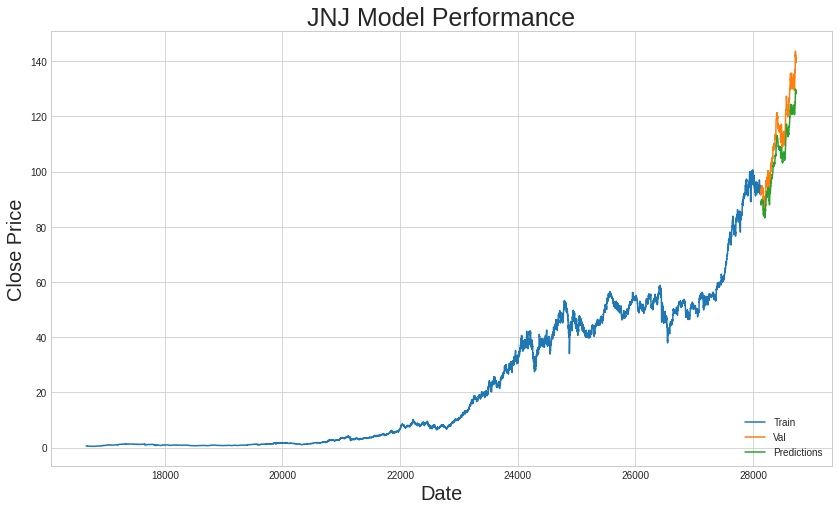

In [18]:
plot_results('JNJ',c2, l, pred)

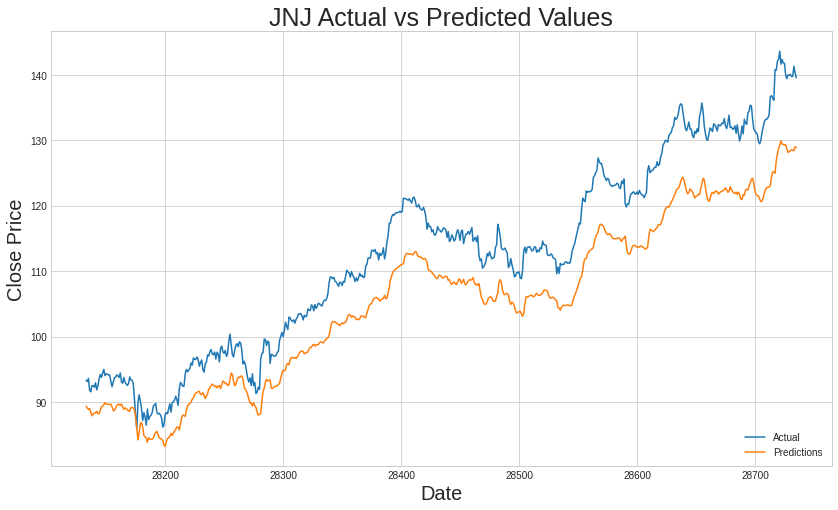

In [19]:
plot_pred_actual('JNJ',c2, l, pred)

# 5.0 Predict the closing price for JP Morgan

In [20]:
data_array, l = training_data(c3)

In [21]:
scaler, scaled_data = scaling(data_array)

In [22]:
x, y = training_dataset(scaled_data, l)

In [23]:
def lstm_model(x, y):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x.shape[1], 1)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(x, y, batch_size=1, epochs=1)

  return model

In [24]:
lstm_model = lstm_model(x, y)

11411/11411 [==============================] - 368s 32ms/step - loss: 2.1493e-04


In [25]:
score3, pred = lstm_model_predict(scaler, scaled_data, data_array, lstm_model, l)

RMSE: 2.5062628745614184


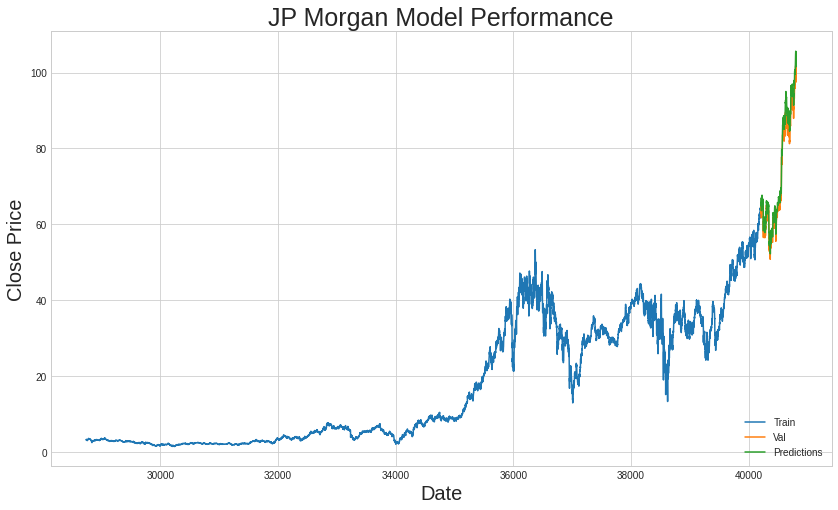

In [26]:
plot_results('JP Morgan',c3, l, pred)

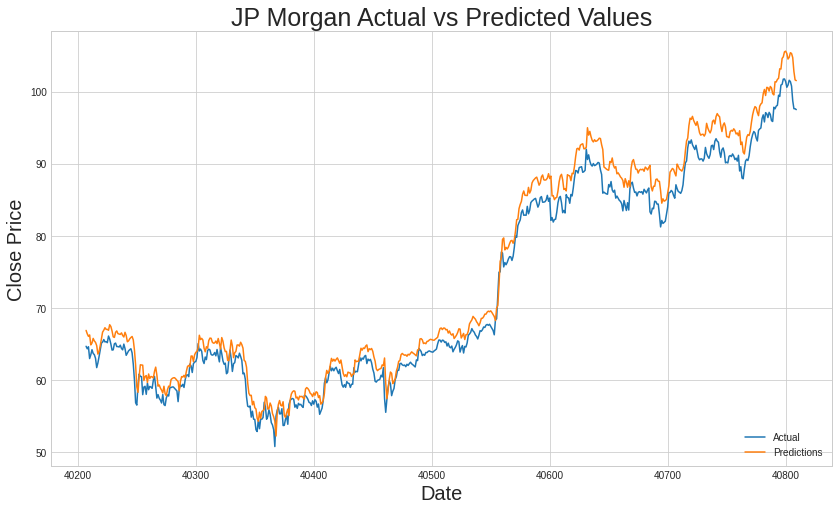

In [27]:
plot_pred_actual('JP Morgan',c3, l, pred)

# 6.0 Predict the closing price for Goldman Sachs

In [28]:
data_array, l = training_data(c1)
scaler, scaled_data = scaling(data_array)

In [29]:
x, y = training_dataset(scaled_data, l)

In [30]:
def lstm_model(x, y):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x.shape[1], 1)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(x, y, batch_size=1, epochs=1)

  return model

In [31]:
lstm_model = lstm_model(x, y)

4368/4368 [==============================] - 144s 32ms/step - loss: 8.4562e-04


In [32]:
score1, pred = lstm_model_predict(scaler, scaled_data, data_array, lstm_model, l)

RMSE: 5.758523157990906


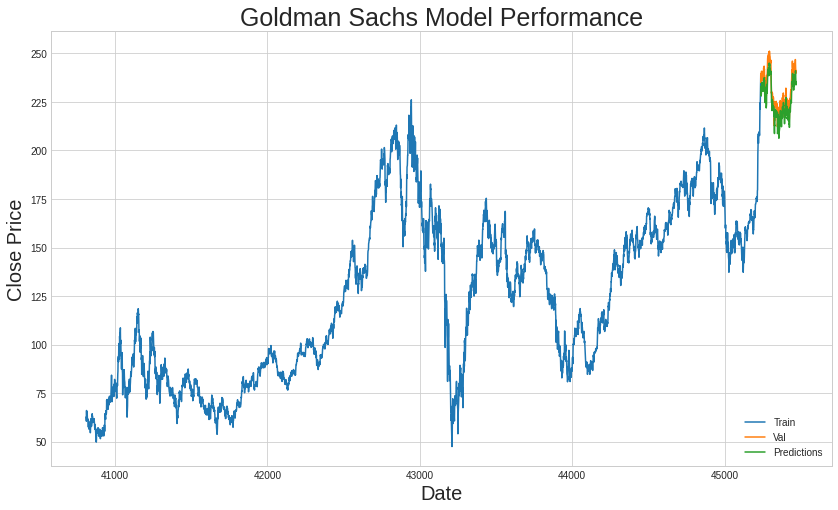

In [33]:
plot_results('Goldman Sachs',c1, l, pred)

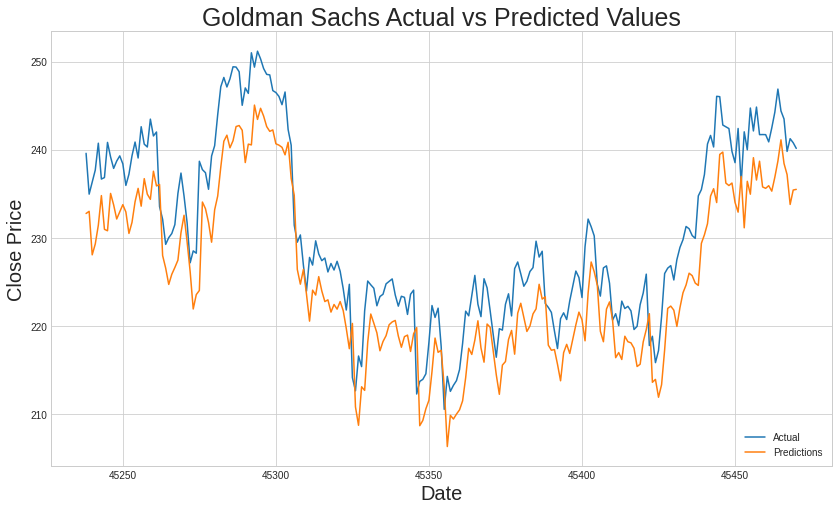

In [34]:
plot_pred_actual('Goldman Sachs',c1, l, pred)

# 7.0 Predict the closing price for Nike

In [35]:
data_array, l = training_data(c4)
scaler, scaled_data = scaling(data_array)

In [36]:
x, y = training_dataset(scaled_data, l)

In [37]:
def lstm_model(x, y):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x.shape[1], 1)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(x, y, batch_size=1, epochs=1)

  return model

In [38]:
lstm_model = lstm_model(x, y)

7179/7179 [==============================] - 233s 32ms/step - loss: 7.0956e-04


In [39]:
score4, pred = lstm_model_predict(scaler, scaled_data, data_array, lstm_model, l)

RMSE: 1.4027050411925364


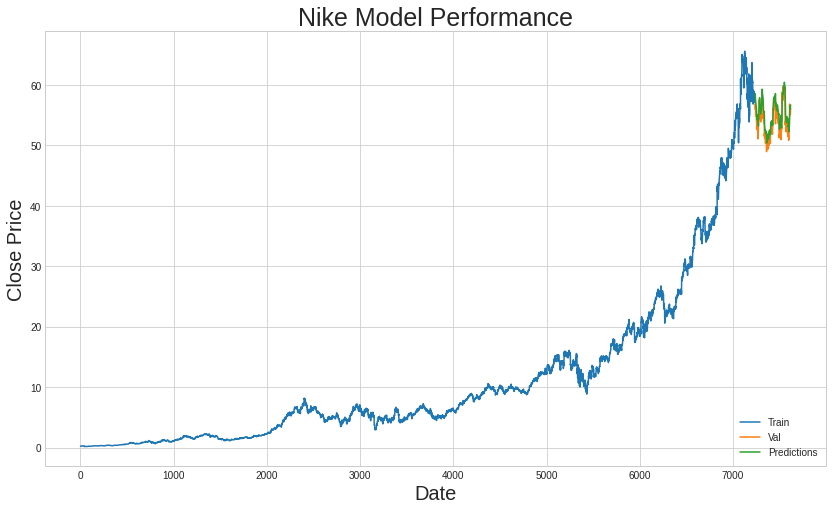

In [40]:
plot_results('Nike',c4, l, pred)

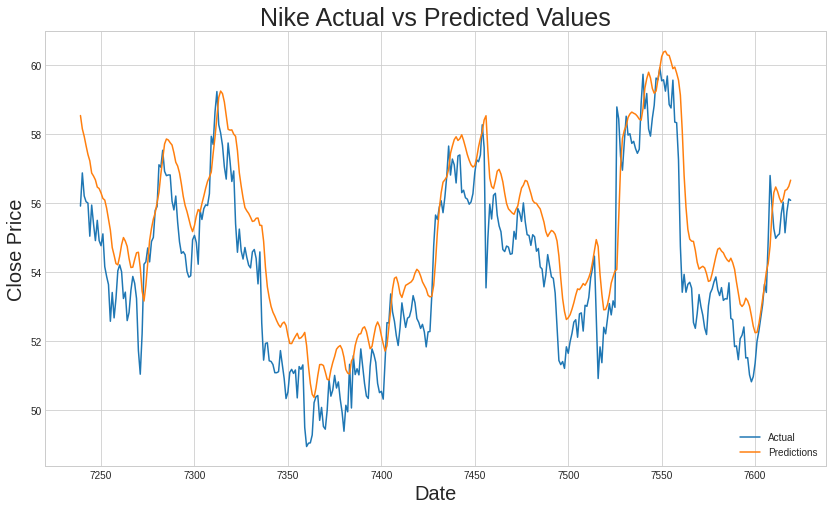

In [41]:
plot_pred_actual('Nike',c4, l, pred)

# 8.0 Predict the closing price for Pfizer

In [42]:
data_array, l = training_data(c5)
scaler, scaled_data = scaling(data_array)

In [43]:
x, y = training_dataset(scaled_data, l)

In [44]:
def lstm_model(x, y):
  # Build the LSTM model
  model = Sequential()
  model.add(LSTM(128, return_sequences=True, input_shape= (x.shape[1], 1)))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(25))
  model.add(Dense(1))

  # Compile the model
  model.compile(optimizer='adam', loss='mean_squared_error')

  # Train the model
  model.fit(x, y, batch_size=1, epochs=1)

  return model

In [45]:
lstm_model = lstm_model(x, y)

8530/8530 [==============================] - 281s 33ms/step - loss: 6.3832e-04


In [46]:
score5, pred = lstm_model_predict(scaler, scaled_data, data_array, lstm_model, l)

RMSE: 0.33765144767570576


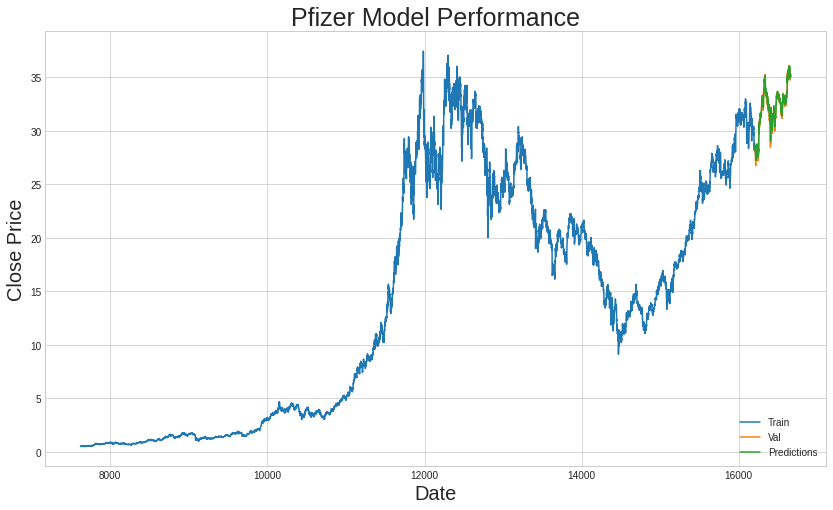

In [47]:
plot_results('Pfizer',c5, l, pred)

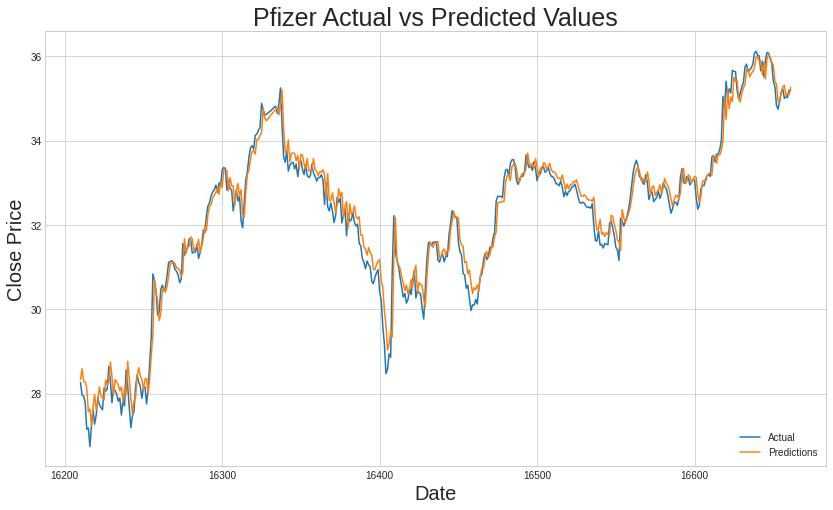

In [48]:
plot_pred_actual('Pfizer',c5, l, pred)

# 9.0 Model Optimization

We're going to use top ten features from correlation analysis and implement dropout to see if it improves our model

## Current Scores

In [49]:
data = {'Company':['Goldman Sachs','JNJ', 'JP Morgan', 'Nike', 'Pfizer'],
        'RMSE Scores':[score1, score2, score3, score4, score5]}
scores1 = pd.DataFrame(data)
scores1

,Company,RMSE Scores
0,Goldman Sachs,5.758523
1,JNJ,7.525105
2,JP Morgan,2.506263
3,Nike,1.402705
4,Pfizer,0.337651


In [50]:
train = test.drop('Unnamed: 0',axis=1)

In [51]:
df_corr = train.corr()
# calculate correlation with target variable
correlation_with_target = df_corr.sort_values('Close')['Close']
print('\nMost Positive:')
display(correlation_with_target.tail(10))


Most Positive:


HC        0.581044
Year      0.606548
HL        0.728268
SMA_21    0.998281
SMA_14    0.998816
SMA_7     0.999309
Open      0.999813
Low       0.999893
High      0.999902
Close     1.000000
Name: Close, dtype: float64

In [52]:
cols=list(correlation_with_target.tail(10).index)

In [53]:
len(cols)

10

In [54]:
c1=train[train.Label.isin([0])]
c2=train[train.Label.isin([1])]
c3=train[train.Label.isin([2])]
c4=train[train.Label.isin([3])]
c5=train[train.Label.isin([4])]

## Training Data

In [55]:
cols.append('Date')

In [170]:
def training_data(data, cols):
  data = data[cols]

  date = data.Date.iloc[math.ceil(data.shape[0]*0.8)] # 80%

  train_df = data[data['Date']<date]
  test_df = data[data['Date']>=date]

  train_df=train_df.drop(['Date'],axis=1).copy()
  test_df=test_df.drop(['Date'],axis=1).copy()

  return train_df, test_df

## Scaling

In [188]:
def scaling(train_df, test_df):
  train_scaler = MinMaxScaler()
  test_scaler = MinMaxScaler()
  train_array=train_scaler.fit_transform(train_df)
  test_array=test_scaler.fit_transform(test_df)

  return train_array, test_array

## Model Build

In [190]:
def training_dataset(train_array,test_array):
  X_train = []
  Y_train = []
  X_test = []
  Y_test = []

  for i in range(60,train_array.shape[0]):
      X_train.append(train_array[i-60:i])
      Y_train.append(train_array[i][9])
      
  for i in range(60,test_array.shape[0]):
      X_test.append(test_array[i-60:i])
      Y_test.append(test_array[i][9])
      
  X_train = np.array(X_train)
  Y_train = np.array(Y_train)
  X_test = np.array(X_test)
  Y_test = np.array(Y_test)
  print(X_train.shape,Y_train.shape,X_test.shape,Y_test.shape)

  return X_train, Y_train, X_test, Y_test

In [191]:
def lstm_model(X_train):
  model = Sequential()
  model.add(LSTM(50,return_sequences = True,input_shape=X_train.shape[1:]))
  model.add(Dropout(0.2))

  model.add(LSTM(60,return_sequences = True))
  model.add(Dropout(0.3))

  model.add(LSTM(80,return_sequences= True))
  model.add(Dropout(0.4))

  model.add(LSTM(120))
  model.add(Dropout(0.5))

  model.add(Dense(1))
  model.summary()

  return model

### JNJ

In [192]:
train_df,test_df=training_data(c2, cols)

In [193]:
train_array,test_array=scaling(train_df, test_df)

In [194]:
X_train,Y_train,X_test,Y_test=training_dataset(train_array,test_array)

(9600, 60, 10) (9600,) (2354, 60, 10) (2354,)


In [195]:
lstm_model=lstm_model(X_train)

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_46 (LSTM)              (None, 60, 50)            12200     
                                                                 
 dropout_36 (Dropout)        (None, 60, 50)            0         
                                                                 
 lstm_47 (LSTM)              (None, 60, 60)            26640     
                                                                 
 dropout_37 (Dropout)        (None, 60, 60)            0         
                                                                 
 lstm_48 (LSTM)              (None, 60, 80)            45120     
                                                                 
 dropout_38 (Dropout)        (None, 60, 80)            0         
                                                                 
 lstm_49 (LSTM)              (None, 120)             

In [196]:
lstm_model.compile(optimizer='adam',loss='mean_squared_error')

In [197]:
lstm_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=128,epochs=10)

Epoch 1/10
75/75 [==============================] - 41s 464ms/step - loss: 0.0114 - val_loss: 0.0010
Epoch 2/10
75/75 [==============================] - 38s 504ms/step - loss: 0.0031 - val_loss: 7.5829e-04
Epoch 3/10
75/75 [==============================] - 36s 476ms/step - loss: 0.0027 - val_loss: 8.7280e-04
Epoch 4/10
75/75 [==============================] - 34s 455ms/step - loss: 0.0029 - val_loss: 7.1357e-04
Epoch 5/10
75/75 [==============================] - 34s 449ms/step - loss: 0.0024 - val_loss: 6.9834e-04
Epoch 6/10
75/75 [==============================] - 38s 511ms/step - loss: 0.0022 - val_loss: 5.6743e-04
Epoch 7/10
75/75 [==============================] - 36s 473ms/step - loss: 0.0021 - val_loss: 9.4619e-04
Epoch 8/10
75/75 [==============================] - 37s 487ms/step - loss: 0.0022 - val_loss: 5.9322e-04
Epoch 9/10
75/75 [==============================] - 35s 469ms/step - loss: 0.0021 - val_loss: 8.9746e-04
Epoch 10/10
75/75 [==============================] - 35s 46

In [198]:
result = lstm_model.predict(X_test)

In [199]:
# Get the root mean squared error (RMSE)
def get_score(result, Y_test):
  rmse = np.sqrt(np.mean(((result - Y_test) ** 2)))
  print('RMSE:', rmse)
  return rmse
score2 = get_score(result,Y_test)

RMSE: 0.3573404325267531


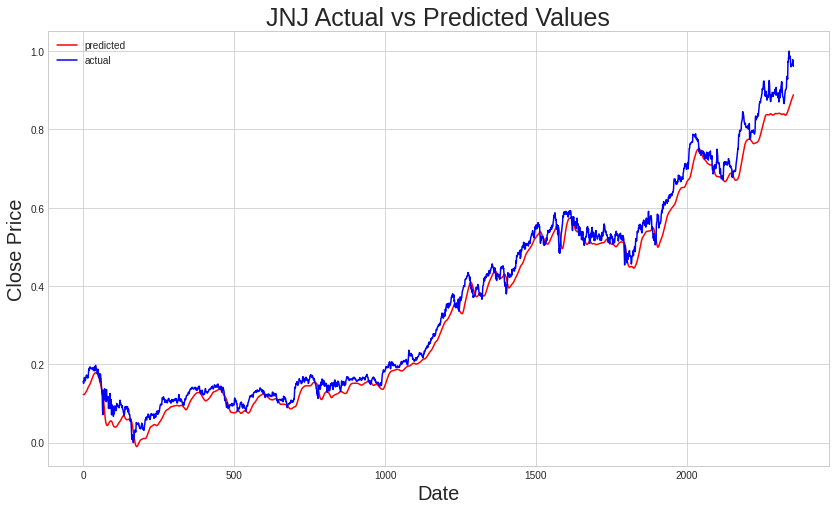

In [200]:
def plot_results(title, result, Y_test):
  plt.figure(figsize=(14,8))
  plt.title(title+' Actual vs Predicted Values',size=25)
  plt.xlabel('Date', fontsize=20)
  plt.ylabel('Close Price', fontsize=20)
  plt.plot(result,color = 'red',label='predicted')
  plt.plot(Y_test,color =  'blue', label = 'actual')
  plt.legend()
  plt.show
plot_results('JNJ',result, Y_test)

### JP Morgan

In [73]:
train_df,test_df=training_data(c3, cols)
train_array,test_array=scaling(train_df, test_df)
X_train,Y_train,X_test,Y_test=training_dataset(train_array,test_array)

(9600, 60, 10) (9600,) (2354, 60, 10) (2354,)


In [74]:
def lstm_model(X_train):
  model = Sequential()
  model.add(LSTM(50,return_sequences = True,input_shape=X_train.shape[1:]))
  model.add(Dropout(0.2))

  model.add(LSTM(60,return_sequences = True))
  model.add(Dropout(0.3))

  model.add(LSTM(80,return_sequences= True))
  model.add(Dropout(0.4))

  model.add(LSTM(120))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  return model

In [75]:
lstm_model=lstm_model(X_train)
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
lstm_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=128,epochs=10)

Epoch 1/10
75/75 [==============================] - 37s 415ms/step - loss: 0.0075 - val_loss: 0.0022
Epoch 2/10
75/75 [==============================] - 29s 392ms/step - loss: 0.0027 - val_loss: 0.0012
Epoch 3/10
75/75 [==============================] - 30s 394ms/step - loss: 0.0025 - val_loss: 0.0014
Epoch 4/10
75/75 [==============================] - 30s 395ms/step - loss: 0.0024 - val_loss: 0.0017
Epoch 5/10
75/75 [==============================] - 30s 396ms/step - loss: 0.0023 - val_loss: 0.0021
Epoch 6/10
75/75 [==============================] - 29s 392ms/step - loss: 0.0020 - val_loss: 0.0017
Epoch 7/10
75/75 [==============================] - 29s 393ms/step - loss: 0.0021 - val_loss: 9.8983e-04
Epoch 8/10
75/75 [==============================] - 29s 391ms/step - loss: 0.0018 - val_loss: 0.0014
Epoch 9/10
75/75 [==============================] - 29s 389ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 10/10
75/75 [==============================] - 29s 391ms/step - loss: 0.0016 - va

RMSE: 0.28746234734788806


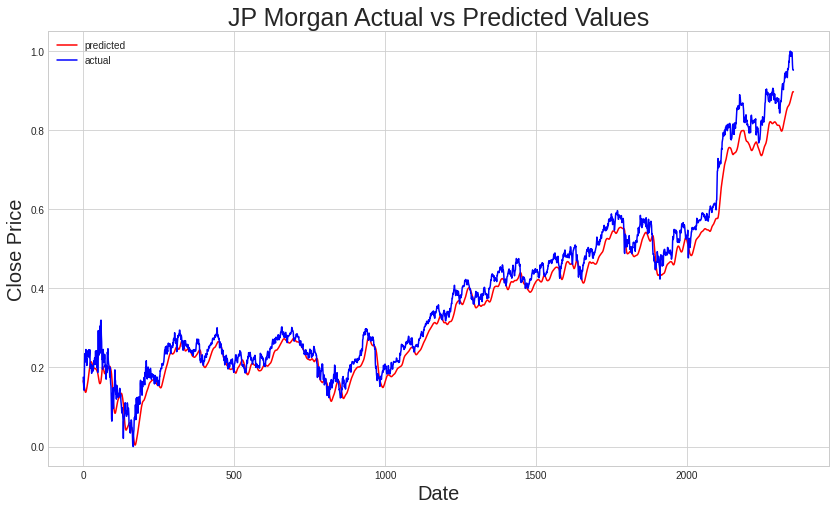

In [76]:
result = lstm_model.predict(X_test)
score3 = get_score(result,Y_test)
plot_results('JP Morgan',result, Y_test)

### Goldman Sachs

In [77]:
train_df,test_df=training_data(c1, cols)
train_array,test_array=scaling(train_df, test_df)
X_train,Y_train,X_test,Y_test=training_dataset(train_array,test_array)

(3669, 60, 10) (3669,) (872, 60, 10) (872,)


In [78]:
def lstm_model(X_train):
  model = Sequential()
  model.add(LSTM(50,return_sequences = True,input_shape=X_train.shape[1:]))
  model.add(Dropout(0.2))

  model.add(LSTM(60,return_sequences = True))
  model.add(Dropout(0.3))

  model.add(LSTM(80,return_sequences= True))
  model.add(Dropout(0.4))

  model.add(LSTM(120))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  return model

In [79]:
lstm_model=lstm_model(X_train)
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
lstm_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=128,epochs=10)

Epoch 1/10
29/29 [==============================] - 21s 479ms/step - loss: 0.0234 - val_loss: 0.0169
Epoch 2/10
29/29 [==============================] - 12s 421ms/step - loss: 0.0063 - val_loss: 0.0082
Epoch 3/10
29/29 [==============================] - 12s 417ms/step - loss: 0.0048 - val_loss: 0.0069
Epoch 4/10
29/29 [==============================] - 12s 419ms/step - loss: 0.0043 - val_loss: 0.0063
Epoch 5/10
29/29 [==============================] - 12s 422ms/step - loss: 0.0043 - val_loss: 0.0048
Epoch 6/10
29/29 [==============================] - 12s 425ms/step - loss: 0.0040 - val_loss: 0.0066
Epoch 7/10
29/29 [==============================] - 12s 422ms/step - loss: 0.0039 - val_loss: 0.0042
Epoch 8/10
29/29 [==============================] - 12s 425ms/step - loss: 0.0039 - val_loss: 0.0044
Epoch 9/10
29/29 [==============================] - 12s 425ms/step - loss: 0.0036 - val_loss: 0.0040
Epoch 10/10
29/29 [==============================] - 12s 422ms/step - loss: 0.0035 - val_lo

RMSE: 0.3452391804943341


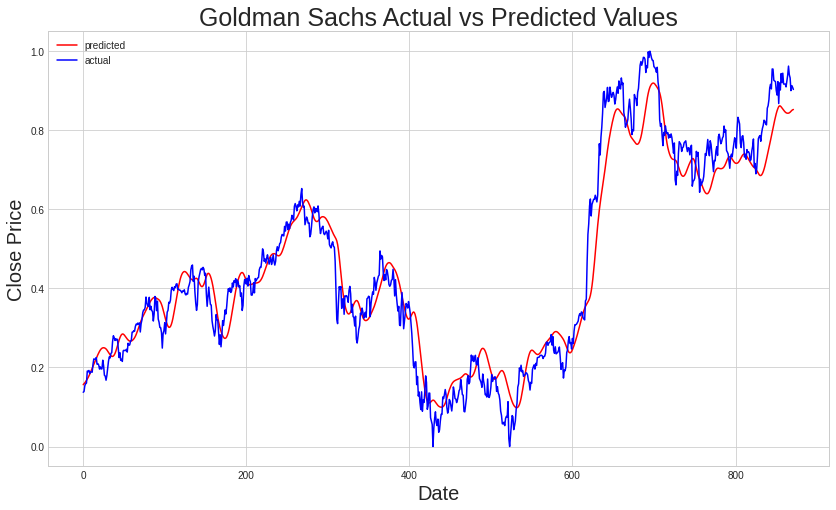

In [80]:
result = lstm_model.predict(X_test)
score1 = get_score(result,Y_test)
plot_results('Goldman Sachs',result, Y_test)

### Nike

In [81]:
train_df,test_df=training_data(c4, cols)
train_array,test_array=scaling(train_df, test_df)
X_train,Y_train,X_test,Y_test=training_dataset(train_array,test_array)

(6036, 60, 10) (6036,) (1464, 60, 10) (1464,)


In [82]:
def lstm_model(X_train):
  model = Sequential()
  model.add(LSTM(50,return_sequences = True,input_shape=X_train.shape[1:]))
  model.add(Dropout(0.2))

  model.add(LSTM(60,return_sequences = True))
  model.add(Dropout(0.3))

  model.add(LSTM(80,return_sequences= True))
  model.add(Dropout(0.4))

  model.add(LSTM(120))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  return model

In [83]:
lstm_model=lstm_model(X_train)
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
lstm_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=128,epochs=10)

Epoch 1/10
48/48 [==============================] - 29s 453ms/step - loss: 0.0116 - val_loss: 0.0052
Epoch 2/10
48/48 [==============================] - 20s 417ms/step - loss: 0.0028 - val_loss: 0.0048
Epoch 3/10
48/48 [==============================] - 20s 420ms/step - loss: 0.0025 - val_loss: 0.0053
Epoch 4/10
48/48 [==============================] - 20s 422ms/step - loss: 0.0025 - val_loss: 0.0019
Epoch 5/10
48/48 [==============================] - 20s 421ms/step - loss: 0.0023 - val_loss: 0.0029
Epoch 6/10
48/48 [==============================] - 20s 421ms/step - loss: 0.0020 - val_loss: 0.0022
Epoch 7/10
48/48 [==============================] - 20s 419ms/step - loss: 0.0020 - val_loss: 0.0031
Epoch 8/10
48/48 [==============================] - 20s 422ms/step - loss: 0.0020 - val_loss: 0.0032
Epoch 9/10
48/48 [==============================] - 20s 422ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 10/10
48/48 [==============================] - 20s 423ms/step - loss: 0.0018 - val_lo

RMSE: 0.41899045166326315


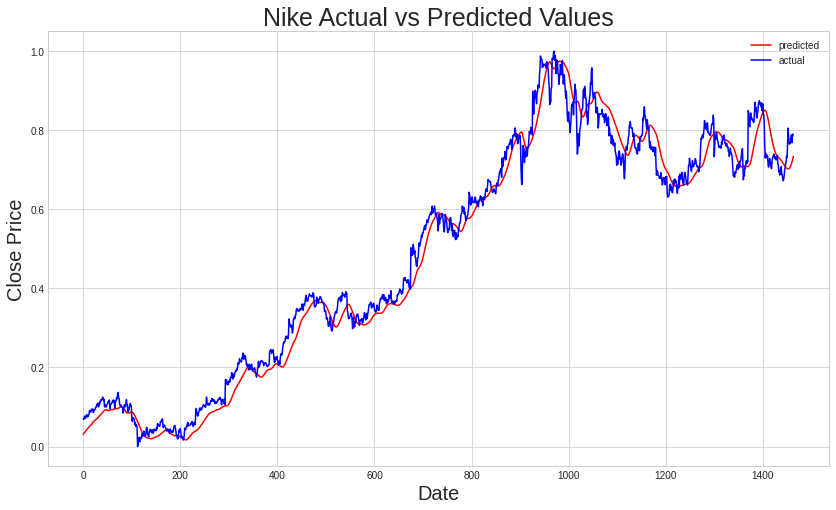

In [84]:
result = lstm_model.predict(X_test)
score4 = get_score(result,Y_test)
plot_results('Nike',result, Y_test)

### Pfizer

In [85]:
train_df,test_df=training_data(c5, cols)
train_array,test_array=scaling(train_df, test_df)
X_train,Y_train,X_test,Y_test=training_dataset(train_array,test_array)

(7174, 60, 10) (7174,) (1748, 60, 10) (1748,)


In [86]:
def lstm_model(X_train):
  model = Sequential()
  model.add(LSTM(50,return_sequences = True,input_shape=X_train.shape[1:]))
  model.add(Dropout(0.2))

  model.add(LSTM(60,return_sequences = True))
  model.add(Dropout(0.3))

  model.add(LSTM(80,return_sequences= True))
  model.add(Dropout(0.4))

  model.add(LSTM(120))
  model.add(Dropout(0.5))

  model.add(Dense(1))

  return model

In [87]:
lstm_model=lstm_model(X_train)
lstm_model.compile(optimizer='adam',loss='mean_squared_error')
lstm_model.fit(X_train,Y_train,validation_data=(X_test,Y_test),batch_size=128,epochs=10)

Epoch 1/10
57/57 [==============================] - 33s 457ms/step - loss: 0.0126 - val_loss: 0.0067
Epoch 2/10
57/57 [==============================] - 24s 420ms/step - loss: 0.0039 - val_loss: 0.0027
Epoch 3/10
57/57 [==============================] - 24s 421ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 4/10
57/57 [==============================] - 24s 425ms/step - loss: 0.0030 - val_loss: 0.0025
Epoch 5/10
57/57 [==============================] - 24s 420ms/step - loss: 0.0028 - val_loss: 0.0064
Epoch 6/10
57/57 [==============================] - 24s 422ms/step - loss: 0.0026 - val_loss: 0.0029
Epoch 7/10
57/57 [==============================] - 24s 424ms/step - loss: 0.0025 - val_loss: 0.0021
Epoch 8/10
57/57 [==============================] - 24s 421ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 9/10
57/57 [==============================] - 24s 422ms/step - loss: 0.0024 - val_loss: 0.0055
Epoch 10/10
57/57 [==============================] - 24s 422ms/step - loss: 0.0032 - val_lo

RMSE: 0.3698969594083529


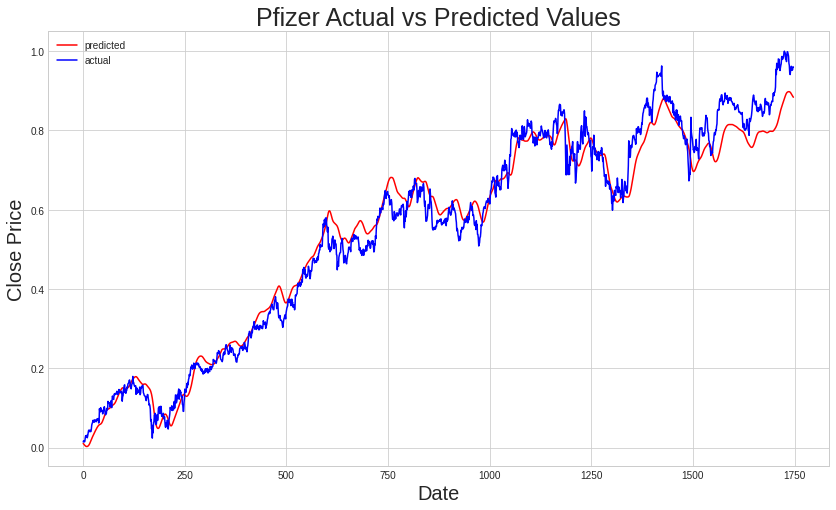

In [94]:
result = lstm_model.predict(X_test)
score5 = get_score(result,Y_test)
plot_results('Pfizer',result, Y_test)

## Final Scores

In [201]:
data = {'Company':['Goldman Sachs','JNJ', 'JP Morgan', 'Nike', 'Pfizer'],
        'RMSE Scores':[score1, score2, score3, score4, score5]}
scores2 = pd.DataFrame(data)
scores2

,Company,RMSE Scores
0,Goldman Sachs,0.345239
1,JNJ,0.357340
2,JP Morgan,0.287462
3,Nike,0.418990
4,Pfizer,0.369897


* Based on a rule of thumb, it can be said that RMSE values between 0.2 and 0.5 shows that the model can relatively predict the data accurately